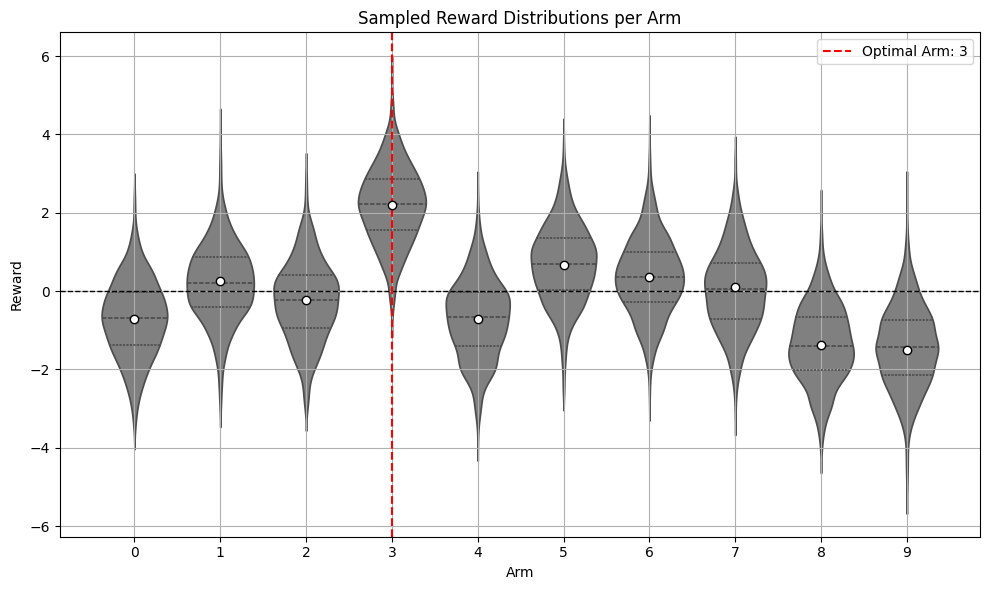

In [34]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy.stats

np.random.seed(1331)

arms = 10 # number of bandit arms
steps = 2000
runs = 1000
epsilons = [0.01, 0.05, 0.1, 0.2, 0.5]
alphas = [0.01, 0.05, 0.1, 0.2, 0.5]

# shared noise
shared_noise = np.random.normal(0, 0.01, size=(runs, steps, arms))

# shared permutation of arms
shared_perm = np.random.permutation(arms)

class Bandit:
    def __init__(self, stationary=True, drift=False, mean_reverting=False, abrupt=False, noise_seq=None, perm=None, run_id=None):
        self.stationary = stationary
        self.drift = drift
        self.mean_reverting = mean_reverting
        self.abrupt = abrupt
        self.mu_init = np.random.normal(0, 1, arms) # initial means for each arm
        self.noise_seq = noise_seq
        self.perm = perm
        self.run_id = run_id

    def reset(self):
        # resey time
        self.t = 0
        self.mu = self.mu_init.copy()

    def step(self, action):
        self.t += 1

        if not self.stationary:
            noise = self.noise_seq[self.run_id, self.t - 1]
            if self.drift:
                self.mu += noise
            elif self.mean_reverting:
                self.mu = 0.5 * self.mu + noise

            if self.abrupt and self.t == 501:
                self.mu = self.mu[self.perm]

        # generate reward
        reward = np.random.normal(self.mu[action], 1)

        # check if selected action is optimal
        optimal = action == np.argmax(self.mu)

        return reward, optimal


env = Bandit()
mu_init = env.mu_init

# sample rewards from intial distributions
samples = []
for i, m in enumerate(mu_init):
    rewards = np.random.normal(m, 1, 1000)
    samples.extend(zip([i] * 1000, rewards))
df = pd.DataFrame(samples, columns=['Arm', 'Reward'])

# get optimal arm
optimal_arm = np.argmax(mu_init)

# plot
fig, ax = plt.subplots(figsize=(10, 6))
sns.violinplot(x="Arm", y="Reward", data=df, inner='quartile', color="gray", ax=ax)
ax.axhline(0, color='black', linestyle='--', linewidth=1)
ax.axvline(optimal_arm, color='red', linestyle='--', linewidth=1.5, label=f"Optimal Arm: {optimal_arm}")
for i, mu in enumerate(mu_init):
    ax.plot(i, mu, 'wo', markersize=6, markeredgecolor='black')

ax.set_title('Sampled Reward Distributions per Arm')
ax.set_xlabel('Arm')
ax.set_ylabel('Reward')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

#### **Agents**

In [2]:
class Greedy:
    def __init__(self):
        self.reset()

    def reset(self):
        self.Q = np.zeros(arms) # action-value estimates
        self.N = np.zeros(arms) # action counts

    def select_action(self):
        return np.random.choice(np.flatnonzero(self.Q == self.Q.max()))

    def update(self, action, reward):
        # incremental update of Q value
        self.N[action] += 1
        self.Q[action] += (reward - self.Q[action]) / self.N[action]

    def hard_reset(self):
        # reset to 0
        self.Q[:] = 0
        self.N[:] = 0


class EpsilonGreedy:
    def __init__(self, epsilon):
        self.epsilon = epsilon
        self.reset()

    def reset(self):
        self.Q = np.zeros(arms) # action-value estimatse
        self.N = np.zeros(arms) # action counts

    def select_action(self):
        if np.random.rand() < self.epsilon:
            return np.random.randint(arms)
        return np.random.choice(np.flatnonzero(self.Q == self.Q.max()))

    def update(self, action, reward):
        # incremental update of Q value
        self.N[action] += 1
        self.Q[action] += (reward - self.Q[action]) / self.N[action]

    def hard_reset(self):
        # reste to 0
        self.Q[:] = 0
        self.N[:] = 0


class OptimisticGreedy:
    def __init__(self, mu_init):
        self.mu_init = mu_init # true mean for each arm
        self.reset()

    def reset(self):
        # using 99.5th percentile of best distribution to initialize Q
        max_mu = np.max(self.mu_init)
        optimistic_value = scipy.stats.norm.ppf(0.995, loc=max_mu, scale=1)
        self.Q = np.ones(arms) * optimistic_value
        self.N = np.zeros(arms)

    def select_action(self):
        return np.random.choice(np.flatnonzero(self.Q == self.Q.max()))

    def update(self, action, reward):
        self.N[action] += 1
        self.Q[action] += (reward - self.Q[action]) / self.N[action]

    def hard_reset(self):
        self.Q[:] = 0
        self.N[:] = 0


class GradientBandit:
    def __init__(self, alpha):
        self.alpha = alpha
        self.reset()

    def reset(self):
        self.H = np.zeros(arms) # action preferences
        self.avg_reward = 0
        self.t = 0

    def select_action(self):
        probs = self._softmax(self.H)
        return np.random.choice(arms, p=probs)

    def update(self, action, reward):
        # update avg reward
        self.t += 1
        self.avg_reward += (reward - self.avg_reward) / self.t

        # get probabilities
        probs = self._softmax(self.H)

        # gradient ascent update rule
        for i in range(arms):
            self.H[i] += self.alpha * (reward - self.avg_reward) * ((i == action) - probs[i])

    def _softmax(self, x):
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum()

    def hard_reset(self):
        self.reset()

#### **Simulation Function**

In [28]:
def simulate(agent_class, stationary=True, hard_reset=False, **agent_kwargs):
    # intialize array to store rewards and optimal actions
    rewards = np.zeros((runs, steps))
    optimal = np.zeros((runs, steps))

    for run in tqdm(range(runs)):
        if not stationary:
            env = Bandit(
                stationary=False,
                drift=agent_kwargs.get("drift", False),
                mean_reverting=agent_kwargs.get("mean_reverting", False),
                abrupt=agent_kwargs.get("abrupt", False),
                noise_seq=shared_noise,
                perm=shared_perm,
                run_id=run
            )
        else:
            env = Bandit()

        if agent_class == OptimisticGreedy:
            agent_kwargs['mu_init'] = env.mu_init.copy()

        # pass args valid for agent
        args = {k: v for k, v in agent_kwargs.items() if k in agent_class.__init__.__code__.co_varnames}

        agent = agent_class(**args) # intializa agent
        env.reset() # reset environment
        agent.reset() # reset agent

        for t in range(steps):
            if t == 501 and hard_reset:
                agent.hard_reset()

            action = agent.select_action()
            reward, is_optimal = env.step(action)
            agent.update(action, reward)
            rewards[run, t] = reward
            optimal[run, t] = is_optimal

    return rewards, optimal

#### **Tuning**

##### **Epsilon**


Tuning Epsilon:



100%|██████████| 1000/1000 [00:54<00:00, 18.29it/s]


Epsilon = 0.01:
Avg. Reward = 1.2725
% Optimal = 57.78%



100%|██████████| 1000/1000 [00:52<00:00, 19.10it/s]


Epsilon = 0.05:
Avg. Reward = 1.4122
% Optimal = 77.26%



100%|██████████| 1000/1000 [00:51<00:00, 19.30it/s]


Epsilon = 0.1:
Avg. Reward = 1.3315
% Optimal = 76.20%



100%|██████████| 1000/1000 [00:48<00:00, 20.66it/s]


Epsilon = 0.2:
Avg. Reward = 1.1937
% Optimal = 69.72%



100%|██████████| 1000/1000 [00:41<00:00, 23.92it/s]


Epsilon = 0.5:
Avg. Reward = 0.7490
% Optimal = 50.50%



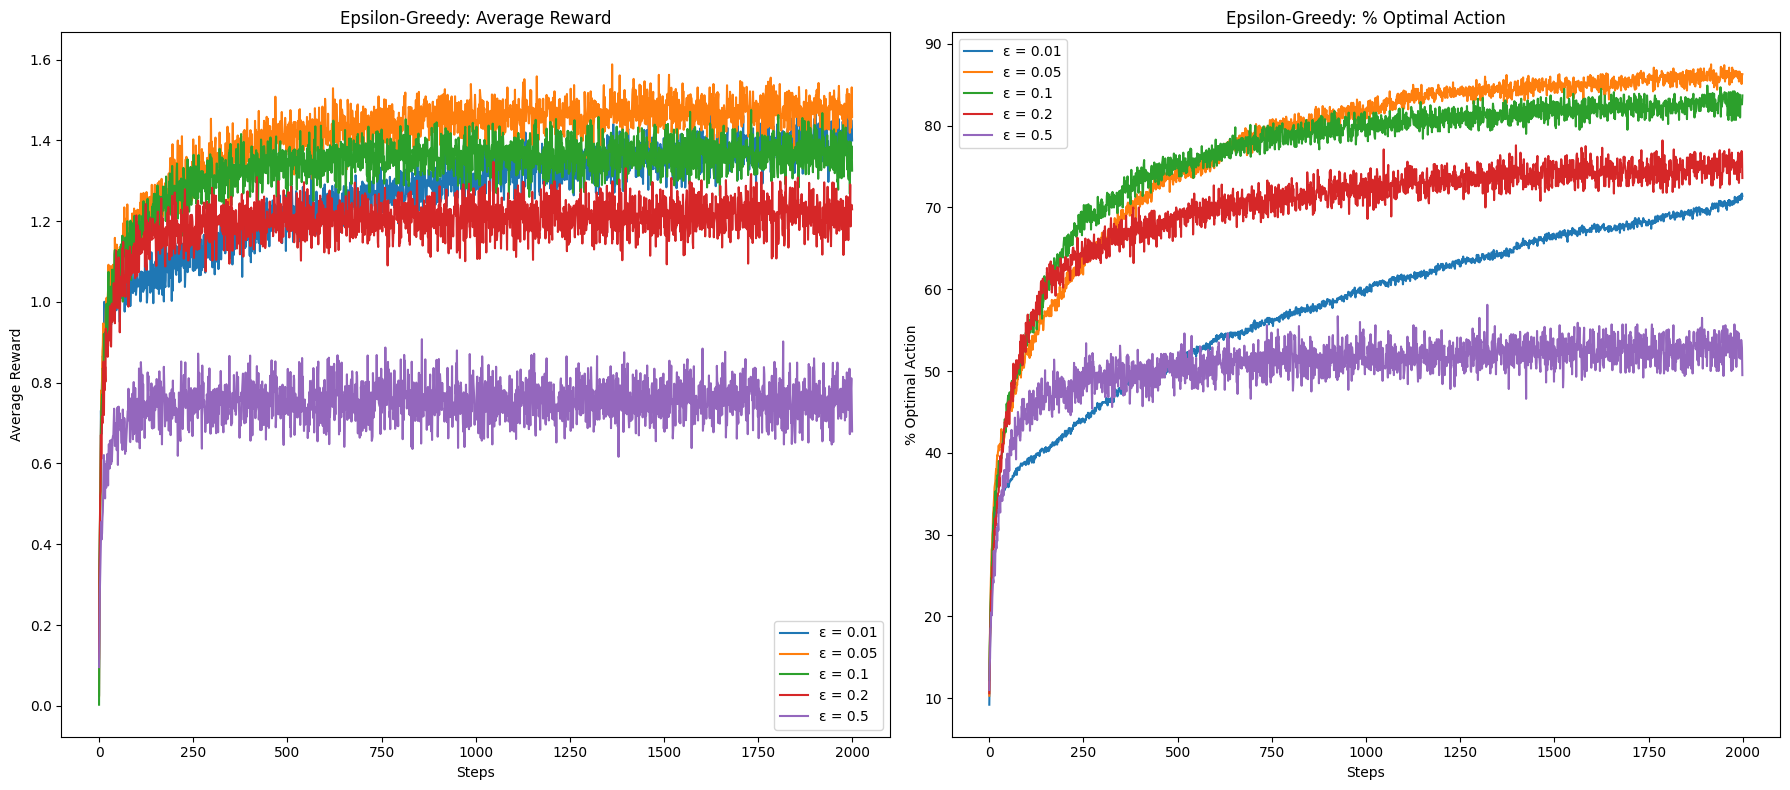


Best Epsilon: 0.05



In [13]:
def tune_epsilon():
    best_score = -np.inf
    best_eps = None
    fig, axs = plt.subplots(1, 2, figsize=(18, 8), sharex=True)

    print("\nTuning Epsilon:\n")
    for eps in epsilons:
        rewards, optimal = simulate(EpsilonGreedy, epsilon=eps)

        # compute average rewrads and % of optimal actions
        avg_reward = rewards.mean()
        avg_optimal = optimal.mean() * 100
        print(f"Epsilon = {eps}:\nAvg. Reward = {avg_reward:.4f}\n% Optimal = {avg_optimal:.2f}%\n")

        avg_rewards = rewards.mean(axis=0)
        opt_percent = optimal.mean(axis=0) * 100
        axs[0].plot(avg_rewards, label=f"ε = {eps}")
        axs[1].plot(opt_percent, label=f"ε = {eps}")

        # update best epsilon
        if avg_reward > best_score:
            best_score, best_eps = avg_reward, eps

    axs[0].set_title("Epsilon-Greedy: Average Reward")
    axs[1].set_title("Epsilon-Greedy: % Optimal Action")
    for ax in axs:
        ax.set_xlabel("Steps")
        ax.legend()
    axs[0].set_ylabel("Average Reward")
    axs[1].set_ylabel("% Optimal Action")
    plt.tight_layout()
    plt.show()

    print(f"\nBest Epsilon: {best_eps}\n")
    return best_eps

best_epsilon = tune_epsilon()

##### **Alpha**


Tuning alpha:



100%|██████████| 1000/1000 [02:14<00:00,  7.41it/s]


Alpha = 0.01:
Avg. Reward = 0.9010
% Optimal = 48.30%



100%|██████████| 1000/1000 [02:01<00:00,  8.22it/s]


Alpha = 0.05:
Avg. Reward = 1.3942
% Optimal = 78.61%



100%|██████████| 1000/1000 [01:56<00:00,  8.56it/s]


Alpha = 0.1:
Avg. Reward = 1.4591
% Optimal = 82.15%



100%|██████████| 1000/1000 [01:55<00:00,  8.66it/s]


Alpha = 0.2:
Avg. Reward = 1.4539
% Optimal = 77.04%



100%|██████████| 1000/1000 [01:59<00:00,  8.37it/s]


Alpha = 0.5:
Avg. Reward = 1.4054
% Optimal = 68.04%



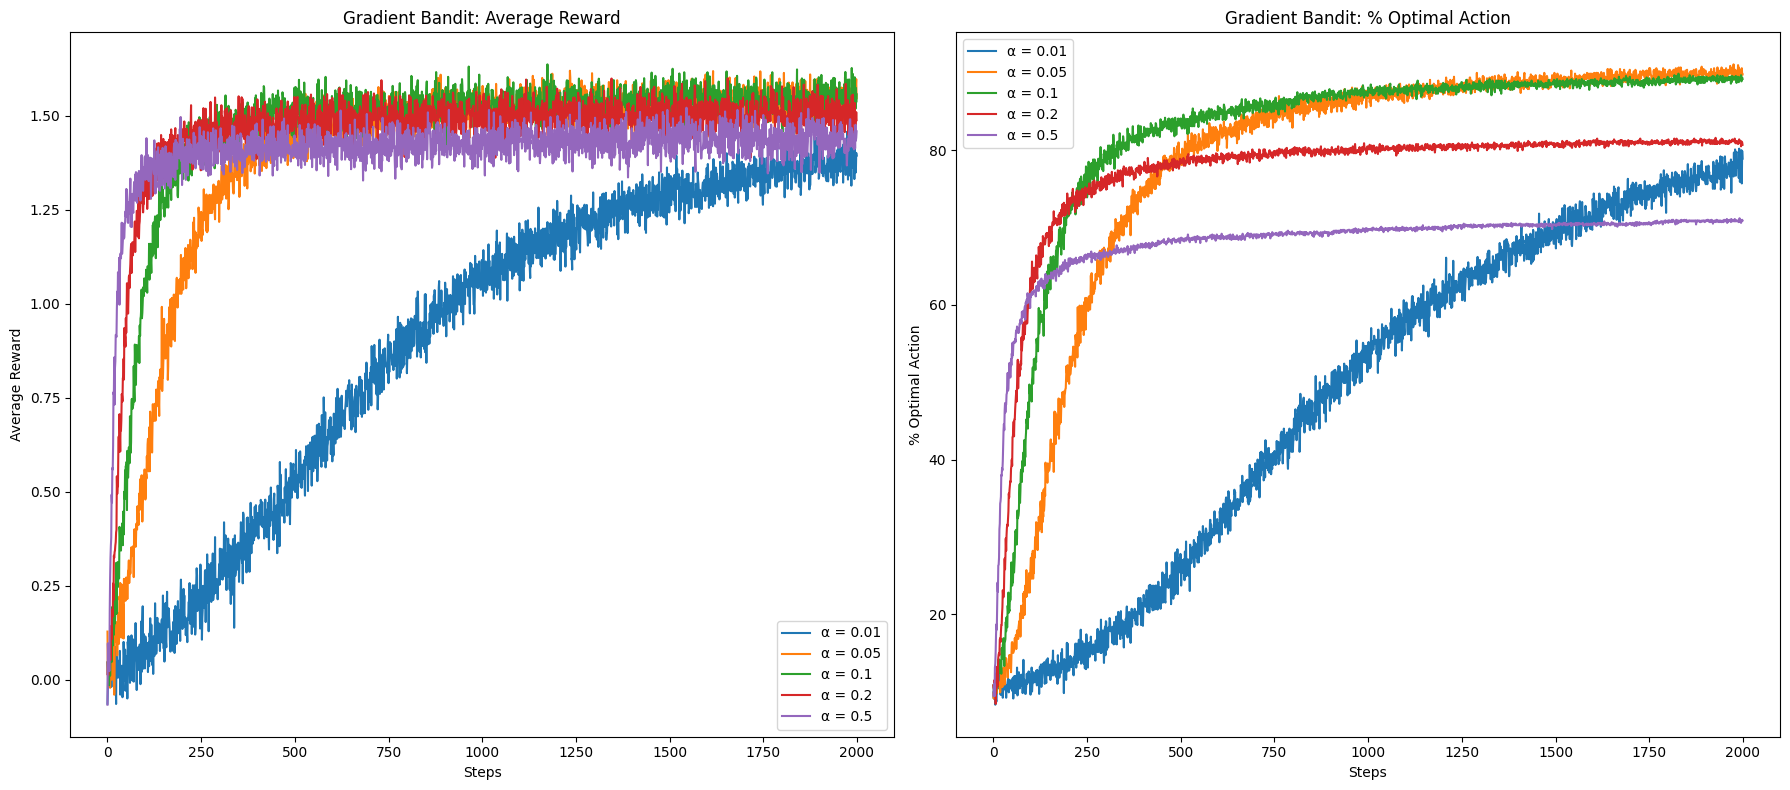


Best alpha: 0.1



In [14]:
def tune_alpha():
    best_score = -np.inf
    best_alpha = None
    fig, axs = plt.subplots(1, 2, figsize=(18, 8), sharex=True)

    print("\nTuning alpha:\n")
    for alpha in alphas:
        rewards, optimal = simulate(GradientBandit, alpha=alpha)

        # compute average rewards and % of optimal actions
        avg_reward = rewards.mean()
        avg_optimal = optimal.mean() * 100
        print(f"Alpha = {alpha}:\nAvg. Reward = {avg_reward:.4f}\n% Optimal = {avg_optimal:.2f}%\n")

        avg_rewards = rewards.mean(axis=0)
        opt_percent = optimal.mean(axis=0) * 100
        axs[0].plot(avg_rewards, label=f"α = {alpha}")
        axs[1].plot(opt_percent, label=f"α = {alpha}")

        # update best alpha
        if avg_reward > best_score:
            best_score, best_alpha = avg_reward, alpha

    axs[0].set_title("Gradient Bandit: Average Reward")
    axs[1].set_title("Gradient Bandit: % Optimal Action")
    for ax in axs:
        ax.set_xlabel("Steps")
        ax.legend()
    axs[0].set_ylabel("Average Reward")
    axs[1].set_ylabel("% Optimal Action")
    plt.tight_layout()
    plt.show()

    print(f"\nBest alpha: {best_alpha}\n")
    return best_alpha

best_alpha = tune_alpha()

#### **Compare Agents**

100%|██████████| 1000/1000 [00:47<00:00, 21.15it/s]


Greedy:
Average Reward = 1.061
Optimal Action = 37.33%



100%|██████████| 1000/1000 [00:47<00:00, 20.86it/s]


Epsilon-Greedy (ε=0.05):
Average Reward = 1.363
Optimal Action = 75.02%



100%|██████████| 1000/1000 [00:47<00:00, 21.05it/s]


Optimistic Greedy:
Average Reward = 1.408
Optimal Action = 68.66%



100%|██████████| 1000/1000 [01:57<00:00,  8.50it/s]


Gradient Bandit (α=0.1):
Average Reward = 1.447
Optimal Action = 81.82%



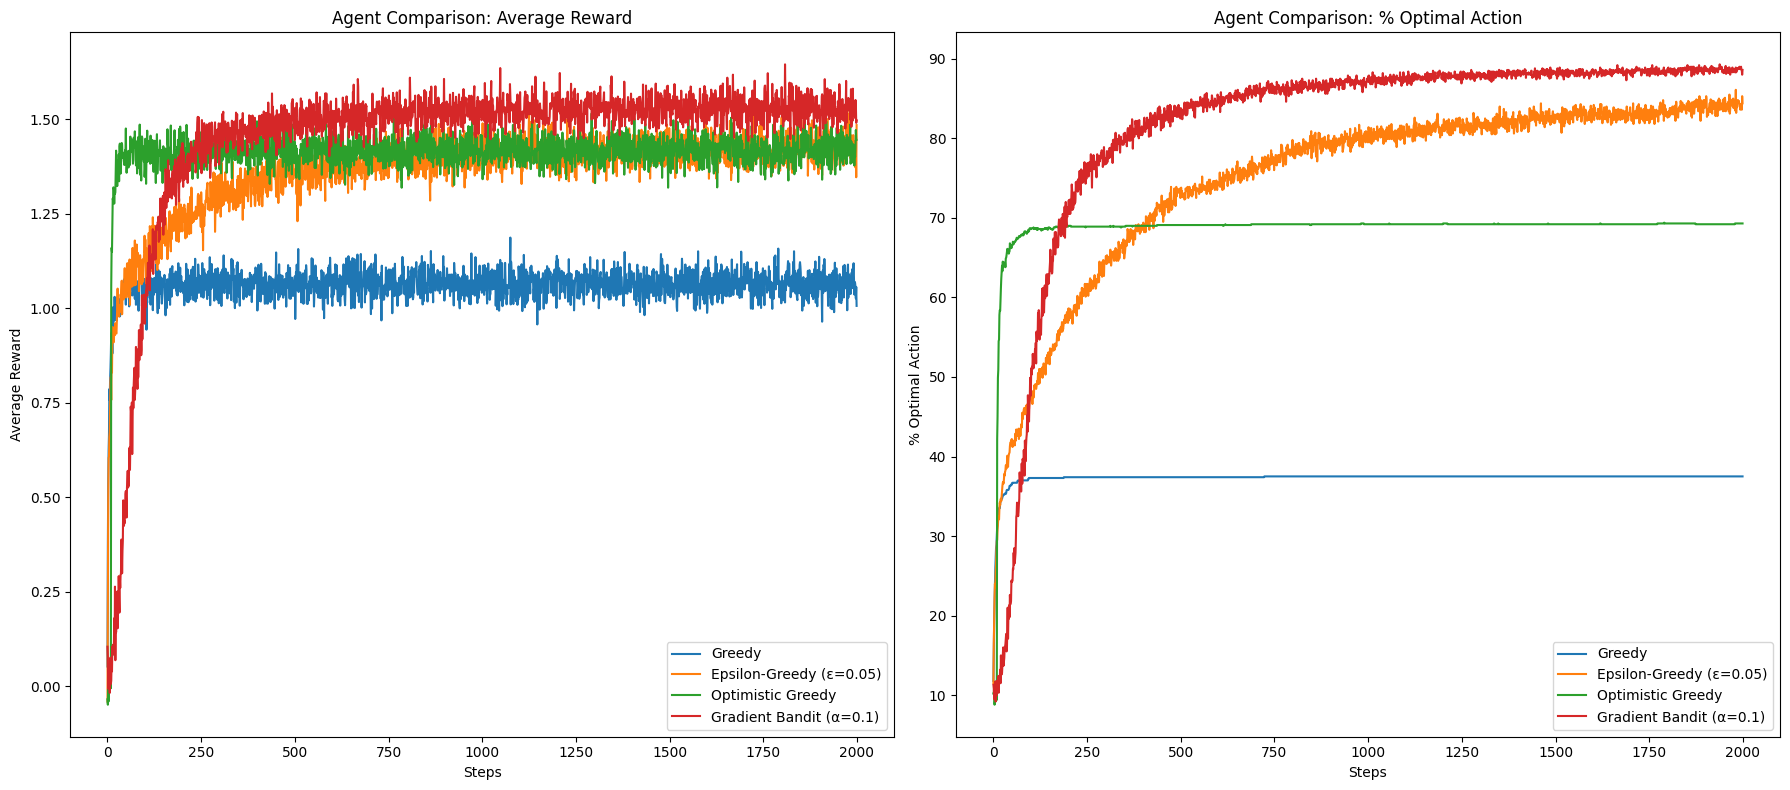

In [15]:
agents = [
        (Greedy, {}, "Greedy"),
        (EpsilonGreedy, {"epsilon": best_epsilon}, f"Epsilon-Greedy (ε={best_epsilon})"),
        (OptimisticGreedy, {}, "Optimistic Greedy"),
        (GradientBandit, {"alpha": best_alpha}, f"Gradient Bandit (α={best_alpha})")
    ]

fig, axs = plt.subplots(1, 2, figsize=(18, 8), sharex=True)

for agent_class, kwargs, label in agents:
    rewards, optimal = simulate(agent_class, **kwargs)

    # compute average rewards and % of optimal actions
    avg_reward = rewards.mean()
    avg_optimal = optimal.mean() * 100
    print(f"{label}:\nAverage Reward = {avg_reward:.3f}\nOptimal Action = {avg_optimal:.2f}%\n")

    avg_rewards = rewards.mean(axis=0)
    opt_percent = optimal.mean(axis=0) * 100
    axs[0].plot(avg_rewards, label=label)
    axs[1].plot(opt_percent, label=label)

axs[0].set_title("Agent Comparison: Average Reward")
axs[1].set_title("Agent Comparison: % Optimal Action")

for ax in axs:
    ax.set_xlabel("Steps")
    ax.legend()

axs[0].set_ylabel("Average Reward")
axs[1].set_ylabel("% Optimal Action")

plt.tight_layout()
plt.show()

#### **Gradual Change**

##### **Drift**

100%|██████████| 1000/1000 [01:06<00:00, 15.04it/s]


Greedy:
Average Reward = 1.050
Optimal Action = 35.69%



100%|██████████| 1000/1000 [01:07<00:00, 14.74it/s]


Epsilon-Greedy (ε=0.05):
Average Reward = 1.435
Optimal Action = 67.26%



100%|██████████| 1000/1000 [01:05<00:00, 15.23it/s]


Optimistic Greedy:
Average Reward = 1.421
Optimal Action = 62.88%



100%|██████████| 1000/1000 [01:54<00:00,  8.70it/s]


Gradient Bandit (α=0.1):
Average Reward = 1.466
Optimal Action = 71.68%



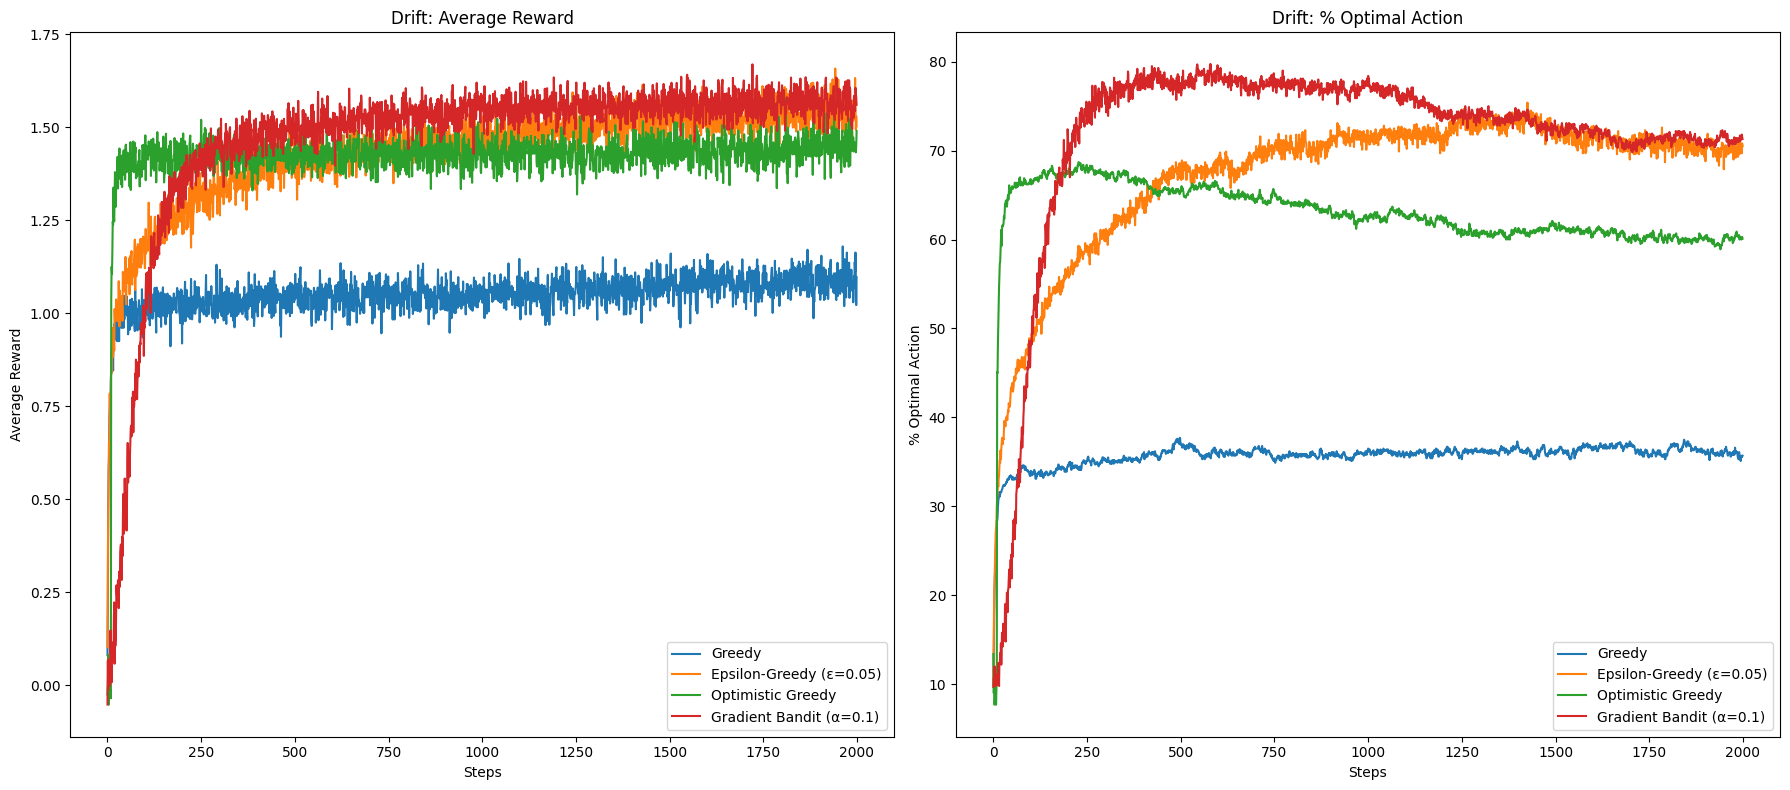

In [23]:
agents = [
    (Greedy, {}, "Greedy"),
    (EpsilonGreedy, {"epsilon": best_epsilon}, f"Epsilon-Greedy (ε={best_epsilon})"),
    (OptimisticGreedy, {}, "Optimistic Greedy"),
    (GradientBandit, {"alpha": best_alpha}, f"Gradient Bandit (α={best_alpha})")
]

fig, axs = plt.subplots(1, 2, figsize=(18, 8), sharex=True)

for agent_class, kwargs, label in agents:
    rewards, optimal = simulate(agent_class, stationary=False, drift=True, **kwargs)

    # compute average rewards and % of optimal actions
    avg_reward = rewards.mean()
    avg_optimal = optimal.mean() * 100
    print(f"{label}:\nAverage Reward = {avg_reward:.3f}\nOptimal Action = {avg_optimal:.2f}%\n")

    avg_rewards = rewards.mean(axis=0)
    opt_percent = optimal.mean(axis=0) * 100

    axs[0].plot(avg_rewards, label=label)
    axs[1].plot(opt_percent, label=label)

axs[0].set_title("Drift: Average Reward")
axs[1].set_title("Drift: % Optimal Action")

for ax in axs:
    ax.set_xlabel("Steps")
    ax.legend()

axs[0].set_ylabel("Average Reward")
axs[1].set_ylabel("% Optimal Action")
plt.tight_layout()
plt.show()


##### **Mean Reverting**

100%|██████████| 1000/1000 [01:10<00:00, 14.23it/s]


Greedy:
Average Reward = 0.000
Optimal Action = 9.98%



100%|██████████| 1000/1000 [01:12<00:00, 13.84it/s]


Epsilon-Greedy (ε=0.05):
Average Reward = -0.000
Optimal Action = 9.99%



100%|██████████| 1000/1000 [01:11<00:00, 14.00it/s]


Optimistic Greedy:
Average Reward = 0.000
Optimal Action = 9.97%



100%|██████████| 1000/1000 [02:00<00:00,  8.30it/s]


Gradient Bandit (α=0.1):
Average Reward = 0.000
Optimal Action = 9.96%



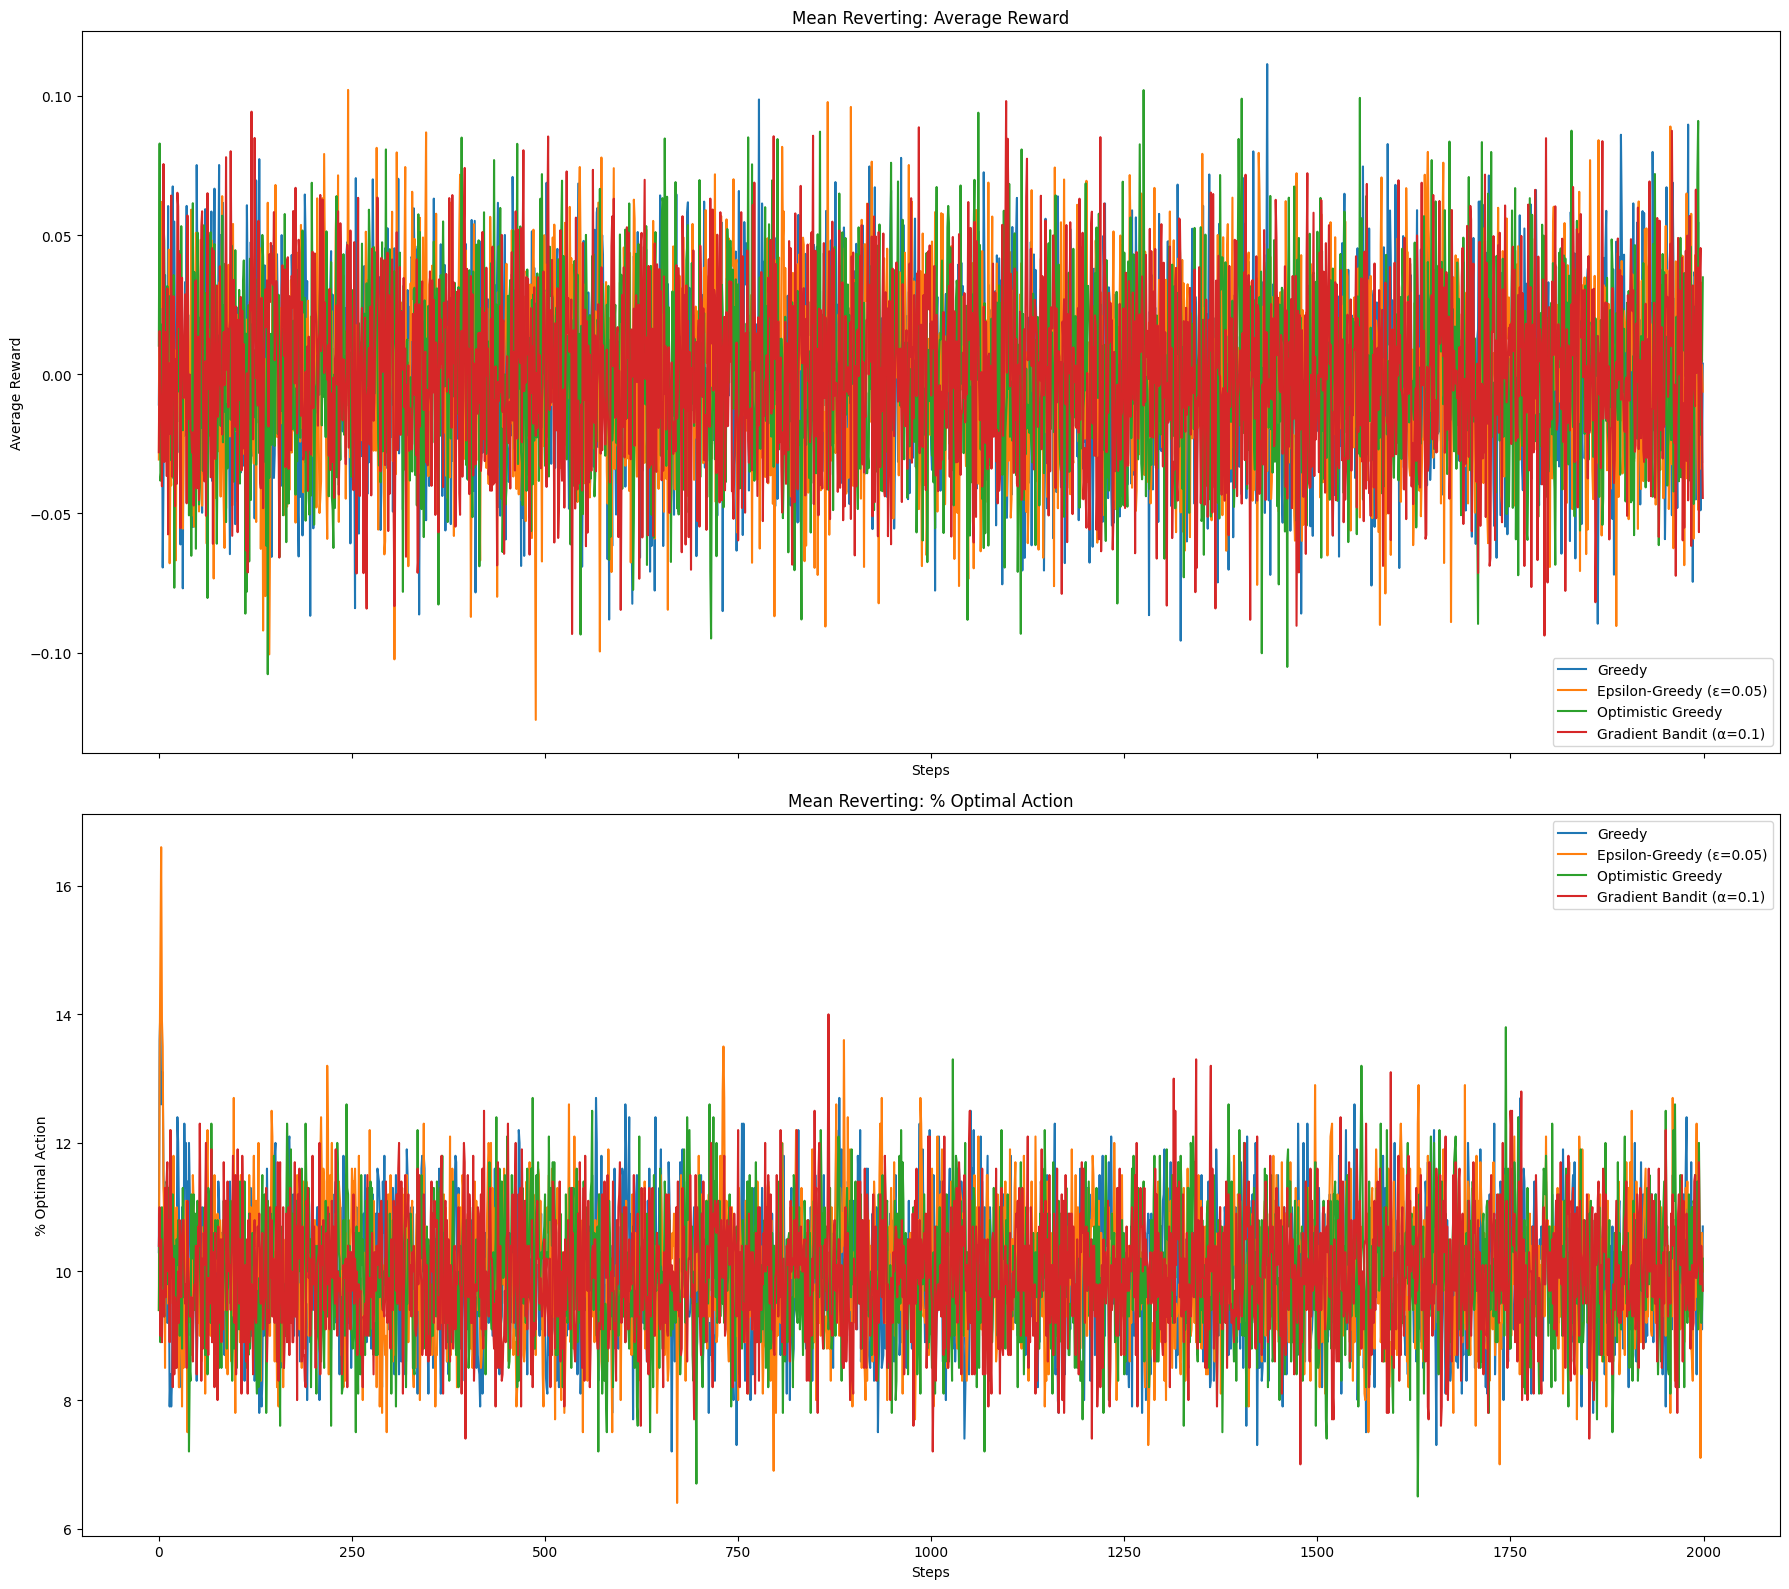

In [24]:
fig, axs = plt.subplots(2, 1, figsize=(18, 16), sharex=True)

for agent_class, kwargs, label in agents:
    rewards, optimal = simulate(agent_class, stationary=False, mean_reverting=True, **kwargs)

    # compute average rewards and % of optimal actions
    avg_reward = rewards.mean()
    avg_optimal = optimal.mean() * 100
    print(f"{label}:\nAverage Reward = {avg_reward:.3f}\nOptimal Action = {avg_optimal:.2f}%\n")

    avg_rewards = rewards.mean(axis=0)
    opt_percent = optimal.mean(axis=0) * 100

    axs[0].plot(avg_rewards, label=label)
    axs[1].plot(opt_percent, label=label)

axs[0].set_title("Mean Reverting: Average Reward")
axs[1].set_title("Mean Reverting: % Optimal Action")

for ax in axs:
    ax.set_xlabel("Steps")
    ax.legend()

axs[0].set_ylabel("Average Reward")
axs[1].set_ylabel("% Optimal Action")
plt.tight_layout()
plt.show()

#### **Abrupt Change**

##### **Without Reset**

100%|██████████| 1000/1000 [00:58<00:00, 17.22it/s]


Greedy:
Average Reward = 0.597
Optimal Action = 22.60%



100%|██████████| 1000/1000 [00:58<00:00, 17.07it/s]


Epsilon-Greedy (ε=0.05):
Average Reward = 1.076
Optimal Action = 47.33%



100%|██████████| 1000/1000 [00:57<00:00, 17.47it/s]


Optimistic Greedy:
Average Reward = 0.824
Optimal Action = 35.06%



100%|██████████| 1000/1000 [01:56<00:00,  8.61it/s]


Gradient Bandit (α=0.1):
Average Reward = 0.769
Optimal Action = 34.12%



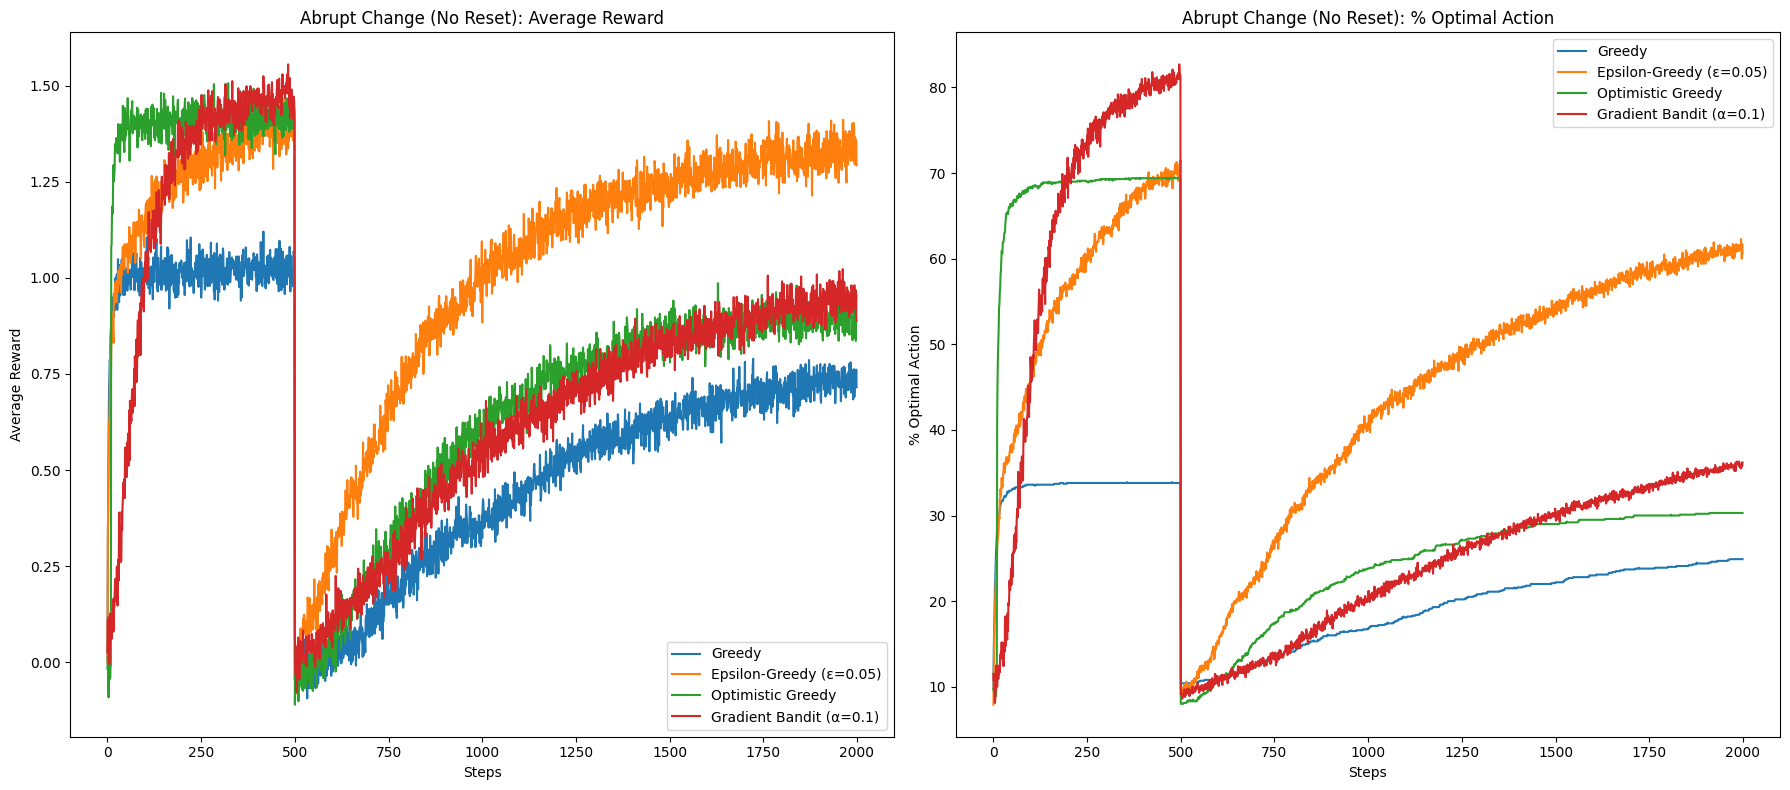

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(18, 8), sharex=True)

for agent_class, kwargs, label in agents:
    rewards, optimal = simulate(agent_class, stationary=False, abrupt=True, **kwargs)

    # compute average rewards and % of optimal actions
    avg_reward = rewards.mean()
    avg_optimal = optimal.mean() * 100
    print(f"{label}:\nAverage Reward = {avg_reward:.3f}\nOptimal Action = {avg_optimal:.2f}%\n")

    avg_rewards = rewards.mean(axis=0)
    opt_percent = optimal.mean(axis=0) * 100

    axs[0].plot(avg_rewards, label=label)
    axs[1].plot(opt_percent, label=label)

axs[0].set_title("Abrupt Change (No Reset): Average Reward")
axs[1].set_title("Abrupt Change (No Reset): % Optimal Action")

for ax in axs:
    ax.set_xlabel("Steps")
    ax.legend()

axs[0].set_ylabel("Average Reward")
axs[1].set_ylabel("% Optimal Action")
plt.tight_layout()
plt.show()


##### **With Reset**

100%|██████████| 1000/1000 [00:56<00:00, 17.57it/s]


Greedy:
Average Reward = 1.033
Optimal Action = 36.84%



100%|██████████| 1000/1000 [00:57<00:00, 17.26it/s]


Epsilon-Greedy (ε=0.05):
Average Reward = 1.327
Optimal Action = 68.15%



100%|██████████| 1000/1000 [00:57<00:00, 17.41it/s]


Optimistic Greedy:
Average Reward = 1.125
Optimal Action = 44.94%



100%|██████████| 1000/1000 [01:57<00:00,  8.53it/s]


Gradient Bandit (α=0.1):
Average Reward = 1.352
Optimal Action = 73.66%



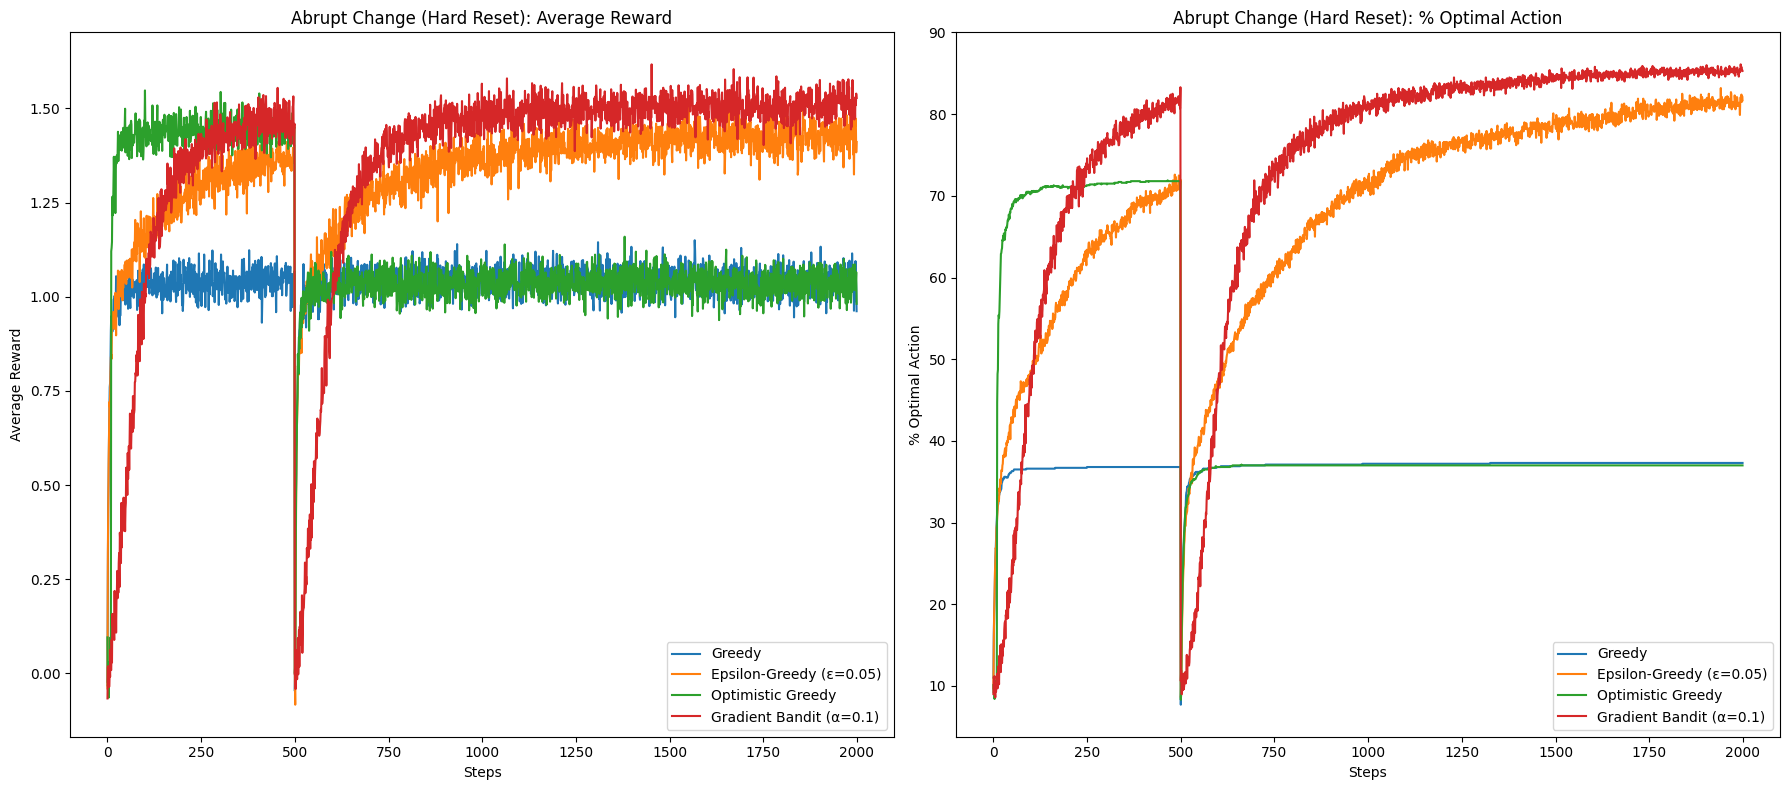

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(18, 8), sharex=True)

for agent_class, kwargs, label in agents:
    rewards, optimal = simulate(agent_class, stationary=False, hard_reset=True, abrupt=True, **kwargs)

    # compute average rewards and % of optimal actions
    avg_reward = rewards.mean()
    avg_optimal = optimal.mean() * 100
    print(f"{label}:\nAverage Reward = {avg_reward:.3f}\nOptimal Action = {avg_optimal:.2f}%\n")

    avg_rewards = rewards.mean(axis=0)
    opt_percent = optimal.mean(axis=0) * 100

    axs[0].plot(avg_rewards, label=label)
    axs[1].plot(opt_percent, label=label)

axs[0].set_title("Abrupt Change (Hard Reset): Average Reward")
axs[1].set_title("Abrupt Change (Hard Reset): % Optimal Action")

for ax in axs:
    ax.set_xlabel("Steps")
    ax.legend()

axs[0].set_ylabel("Average Reward")
axs[1].set_ylabel("% Optimal Action")
plt.tight_layout()
plt.show()